In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as pyplotcolors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.sparse.linalg import svds
%matplotlib inline

In [50]:
import tools
reload(tools)
from tools import *

In [ ]:
mypals = {
    "beige-purple": {"npal": 5, "start": 2.4, "rot": 0.8, "dark": 0., "light": 0.8, "reverse": 1},
}

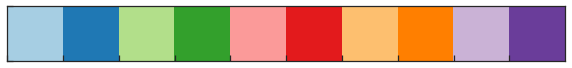

In [9]:
import seaborn as sns
import itertools
sns.set()
sns.set_style("white")
sty = sns.set_style("ticks",{"xtick.major.size":0.8,"ytick.major.size":0.8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
# sns.palplot(sns.color_palette("cubehelix", 8))
# sns.set_palette("cubehelix")

npal = 10
shift = 0
stride = 1
start = 2
rot = 30.0
gamma = 1.0
dark = 0.2
light = 0.8
palnamething = sns.cubehelix_palette(npal,start=start,rot=rot,light=light,dark=dark,reverse=True, gamma=gamma)
palnamething = sns.color_palette("Paired")
# palnamething = sns.color_palette("bright")
sns.set_palette(palnamething, npal)
pal = sns.color_palette(palnamething, npal)
palette = itertools.cycle(pal)
sns.palplot(pal)

for _ in range(shift):
    next(palette)
coldict = {}
for i in range(npal):
    for s in range(1,stride):
        next(palette)
    coldict.update({i:next(palette)})

In [113]:
# PCA params
#
latticemode = True
use_scaling = True
use_xyth = False
use_quadrature = False

In [114]:
# hyperparams
NBRS = np.array([10,15,20,30])
methods = ["random", "radial", "angular", "polar"]
nmethod = len(methods)
n_nbr = 36
nft = n_nbr*3 if use_xyth else n_nbr
run = "defects"
method = methods[3]

source = "/home/walterms/mcmd/nn/data/pca/"
fname = ""
if latticemode:
    prestr = source+"lat_nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = prestr+"_"+str(n_nbr)+"_"+str(method)
else:
    prestr = source+"nbrs_"+run
    if use_xyth: prestr+="_xyth"
    fname = source+"nbrs_"+run+"_"+str(n_nbr)+"_"+str(method)

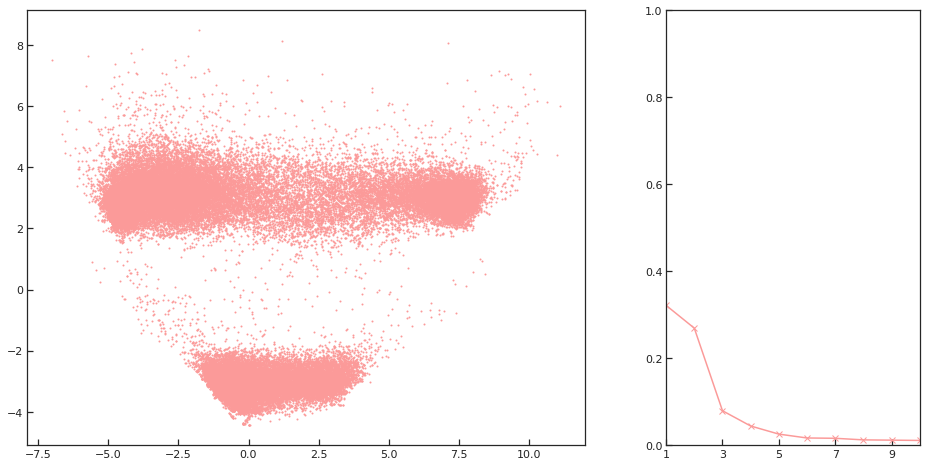

In [116]:
with open(fname) as f:
    for li, l in enumerate(f):
        pass
nsample = li + 1

X = np.empty((nsample,nft))
with open(fname) as fin:
    for i, l in enumerate(fin):
        vals = [float(x) for x in l.split()] #l.split ignores the newline
        X[i] = vals

if use_scaling:
    S = StandardScaler()
    X = S.fit_transform(X)

K = 10 # number reduced dimensions
pca = PCA(n_components=K)
Y = pca.fit_transform(X)
# Y_ = pca.inverse_transform(Y)
if use_quadrature:
    Y = quad_features(Y)
    K -= 2

f,ax = plt.subplots(1,2,figsize=(16,8), gridspec_kw={'width_ratios': [2.2, 1]})
_ = ax[0].scatter(Y[:,0],Y[:,1],s=1,c=coldict[4])
# plt.colorbar(_,ax=ax[0])

ax[1].plot(np.arange(1,11),pca.explained_variance_ratio_,'x-',c=coldict[4])
ax[1].set_ylim(0,1)
ax[1].set_xlim(1,10)
_=ax[1].set_xticks(np.arange(1,11,2))

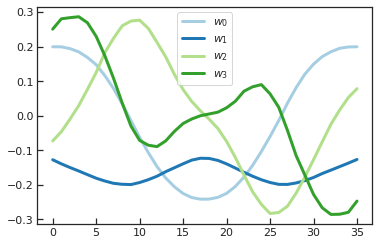

In [112]:
ws = pca.components_[:4]
nc = len(ws)
for i, w_i in enumerate(ws):
    plt.plot(w_i,label=r'$w_%d$'%(i), color=coldict[i],linewidth=3.)
plt.legend()
# plotLine(0,0,n_nbr,0,c='k',ax=plt.gca(),lw=1.0)
# _=plt.xlim(0,n_nbr)


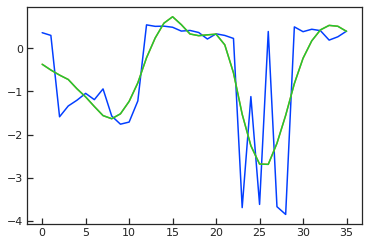

In [97]:
samp = pca.transform(nbrs[1].reshape(1,-1))
construct = np.dot(samp,pca.components_)[0]
pca_inv = pca.inverse_transform(samp[0])
plt.plot(nbrs[1])
plt.plot(pca_inv)
plt.plot(construct)

In [ ]:
# If you want to do inverse stuff
# For sigdim higher than 2, have to use means of higher dimensions
# It turns out that the transform preserves the 0 means so just use 0
f,ax = plt.subplots(1,2,figsize=(12,4))
test = np.zeros((K))
test[:3] = [0,0,1]
test = samp.reshape(10)
if use_quadrature:
    print "You can't pca inverse the quad features"
else:
    test_nbrs = pca.inverse_transform(test)
    if use_scaling:
        test_nbrs = S.inverse_transform(test_nbrs)
    # test_nbrs_trans = S.transform(test_nbrs.reshape(1,-1))
    ax[0].plot(test_nbrs,c="k")
    # ax[0].set_ylim(-1,1)

wi = 1
# ax[1].plot(test_nbrs_trans[0])
# Q = np.array([np.dot(test_nbrs_trans,ww) for ww in ws])
# print Q

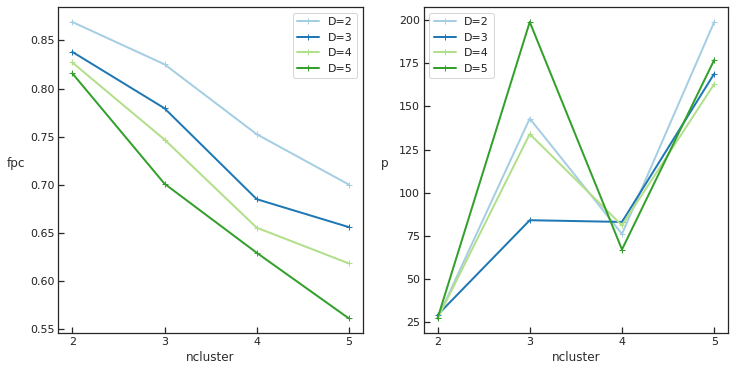

In [54]:
#
# Run fuzzy clustering method
#
NCLUSTERS = np.arange(2,6)
SIGDIMS = np.arange(2,6) # significant dimensions pulled from pca
fpcs = np.zeros(shape=(6,6))
ps = np.zeros(shape=(6,6))
for sigdim in SIGDIMS:
    for ncluster in NCLUSTERS:
        data = Y[:,:sigdim] # Grab first to dims of Y
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            data.T, ncluster, 2, error=0.0001, maxiter=200, init=None)

        # Store fpc values
        fpcs[ncluster,sigdim] = fpc
        ps[ncluster,sigdim] = p
    
#         print sigdim, ncluster, p, fpc
f,ax = plt.subplots(1,2,figsize=(12,6))
for dim in SIGDIMS:
    ax[0].plot(SIGDIMS,fpcs[2:,dim],'+-',label="D=%d"%(dim),c=coldict[dim-SIGDIMS[0]],linewidth=2.0)
    ax[1].plot(SIGDIMS,ps[2:,dim],'+-',label="D=%d"%(dim),c=coldict[dim-SIGDIMS[0]],linewidth=2.0)
     
ax[0].set_ylabel("fpc",rotation="horizontal",labelpad=14)
ax[0].set_xlabel("ncluster")
ax[0].set_xticks(NCLUSTERS)
ax[0].legend()

ax[1].set_ylabel("p",rotation="horizontal",labelpad=14)
ax[1].set_xlabel("ncluster")
ax[1].set_xticks(NCLUSTERS)
ax[1].legend()


In [120]:
# Colouring method
#
use_kmeans = False
use_dims = False # color by first 3 dims
use_1D = True
Dim = 0 # 0 is first dim

# For dim coloring
maxsats = np.max(Y[:,:3],axis=0) - np.min(Y[:,3],axis=0)
minsats = np.min(Y[:,:3],axis=0) + 0.3*maxsats
maxsats *= 0.7

In [39]:
sigdim = 4 # for clustering
ncluster = 3

In [121]:
seed = 1235678

base_colors = np.zeros((nsample,3))
if use_kmeans:
    # SELECT A KMEANS COMBO
    data = Y[:,:sigdim] # Grab first to dims of Y
    kmeans = KMeans(n_clusters=ncluster,max_iter=200,tol=0.0001).fit(data)
    cntr = kmeans.cluster_centers_
    lbls = kmeans.labels_
    for ilbl, lbl in enumerate(lbls):
        base_colors[ilbl] = coldict[lbl]

elif use_dims:
    # Use pca dims for coloring RGB
    P = Y[:,:3]
    for icol,p in enumerate(P):
        P[icol] = np.where(p>maxsats, maxsats, p)
        P[icol] = np.where(p<minsats, minsats, p)
    P = np.subtract(P,minsats)
    P = np.divide(P,maxsats-minsats)
    base_colors = P.copy()    
    
elif use_1D:
    maxsat, minsat = maxsats[Dim], minsats[Dim]
    P = Y[:,Dim]
    P = np.subtract(P,min(P))
    P = np.where(P>maxsat,maxsat,P)
    P = np.where(P<minsat,minsat,P)
    P = np.divide(P,maxsat)
    base_colors[:,2] = P.copy()
    base_colors[:,1] = 1-P.copy()    

else:
    # SELECT A FUZZY COMBO
    data = Y[:,:sigdim] # Grab first to dims of Y
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, ncluster, 2, error=0.000001, maxiter=1000, init=None, seed=seed)
    u = np.transpose(u)
    if u.shape[1] == 2:
        u = np.append(np.zeros((nsample,1)),u,axis=1)
    base_colors = u.copy()

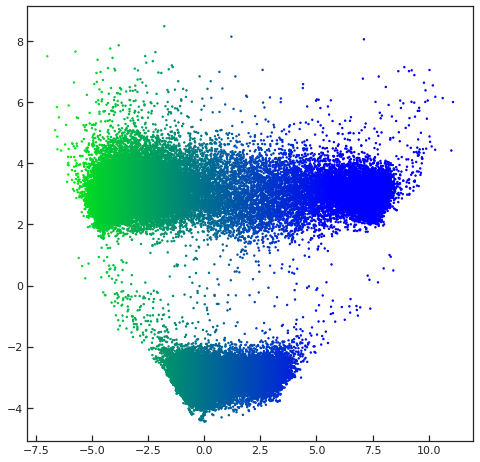

In [122]:
f,ax = plt.subplots(1,1,figsize=(8,8))
_ = ax.scatter(Y[:,0],Y[:,1],s=2,c=base_colors) # for kmeans
if use_kmeans:
    _ = ax.scatter(cntr[:,0],cntr[:,1],marker='x',s=200,c="k",linewidth=4.0)
# _ = ax.set_aspect("equal")

In [130]:
#
# Grab rods from unlbl file
# unlbl files have rod ranges [-0.5,0.5], [-0.5,0.5], [0,1.0]
#
import tools
reload(tools)
from tools import *

# edge = 7.00
# fname = "/home/walterms/mcmd/nn/data/unlbl/edge_3_"+"%0.2f"%(edge)
# globaledge = edge
# nrod = 28**2

# edge = 6.324 # xtud edge
# fname = "/home/walterms/mcmd/nn/data/templates/X"
# globaledge = edge
# nrod = 28**2

# edge = 15. # 15 for bigbox1, 10 for bigbox2
# fname = "/home/walterms/mcmd/nn/data/unlbl/bigbox1" # 60**2 rods for both bigboxes
# globaledge = edge
# nrod = 60**2

edge = 3.
fname = "/home/walterms/mcmd/nn/data/defects/minushalf_reruns"
globaledge = 5.
nrod = 10**2

nblskip = 1 # -1 produces the last snap
nx = 20
nprobe = nx**2
L = 1.0
NBL = 1

if not latticemode:
    nprobe = nrod

probes = gen_probes(nx, edge)

nbl = 0
if nblskip == -1:
    # Count number of blocks
    with open(fname) as fin:
        for i, l in enumerate(fin):
            if l == "\n":
                nbl += 1
    nblskip = nbl - 1

rho = nrod / (edge*edge)
rods = np.empty(shape=(nrod,3))
nbl = 0
irod = 0
with open(fname) as fin:
    for i, l in enumerate(fin):
        if nbl < nblskip:
            if l == "\n":
                nbl += 1
            continue
        if l == "\n":
            # Done block
            break
            
        if l.startswith("label"): continue
        rod = [float(x) for x in l.split()]
        rods[irod] = [globaledge*rod[0], globaledge*rod[1], myrotate(twopi*rod[2])]
        irod += 1

# Transform into higher nbr dimension
nbrs = None
if latticemode:
    nbrs, nbr_coords_full, alphas = get_lat_nbrs(rods,n_nbr,edge,nx,probes,method=method,use_xyth=use_xyth,ret_nbrs=True)
else:
    nbrs = get_nbrs(rods,n_nbr,edge,method=method)
    
if use_scaling:
    nbrs = S.transform(nbrs) # standardize from training set
pca_nbrs = pca.transform(nbrs) # reduce dimensions with pca
if use_quadrature:
    pca_nbrs = quad_features(pca_nbrs)

#
# Probe and colouring
#
probecolors = np.zeros((nprobe,3))

if use_kmeans:
    redu_nbrs = pca_nbrs[:,:sigdim]
    colidxs = kmeans.predict(redu_nbrs)
    for ci,idx in enumerate(colidxs):
        probecolors[ci] = coldict[idx]
    trainset_colors = base_colors.copy()

elif use_1D:
    maxsat = maxsats[Dim]
    minsat = minsats[Dim]
    P = pca_nbrs[:,Dim]
    P = np.subtract(P,min(P))
    P = np.where(P>maxsat,maxsat,P)
    P = np.where(P<minsat,minsat,P)
    P = np.divide(P,max(P))
    probecolors[:,2] = P.copy()
    probecolors[:,1] = 1-P.copy()
    
elif use_dims:
    # Use pca dims for coloring RGB
    P = pca_nbrs[:,:3]
    P_ = np.zeros((nprobe,3))
    for icol,p in enumerate(P):
        P[icol] = np.where(p>maxsats, maxsats, p)
        P[icol] = np.where(p<minsats, minsats, p)
    P = np.subtract(P,minsats)
    P = np.divide(P,maxsats-minsats)
    probecolors = P.copy()

else:
    # Get proximities to centroids
    redu_nbrs = pca_nbrs[:,:sigdim]
    dists = np.empty((nprobe,ncluster))
    for ic in range(ncluster):
        dists[:,ic] = dist_from(cntr[ic],redu_nbrs)

    # Actually, the reciprocals describe how similar
    # a point is to a centroid
    u_probe = normalize(np.reciprocal(dists),axis=1,norm="l1")
    probecolors = u_probe.copy()
    
    if ncluster == 2:
        probecolors = np.append(np.zeros((nprobe,1)),probecolors,axis=1)

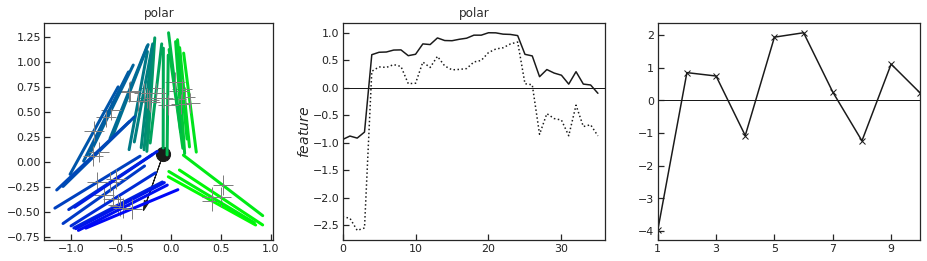

In [131]:
f,ax = plt.subplots(1,3,figsize=(16,4))

ix, iy = 9,9 # x is left-right, y is top-down mod nx
iprob = iy*nx + ix
# iprob = 209
# probe 189 for X, nblskip 5, is a good test case
# 209, defect minusone, nblskip 1 is a perfect X state

test_nbrs = nbr_coords_full[iprob]
for ni, nbr in enumerate(test_nbrs[:,:3]):
    col = (0,1-float(ni)/n_nbr,float(ni)/n_nbr)
    plotrods([nbr],ax[0],col=col,lw=3.,add_crosses=True)
#     plotrods(rods,ax[0])
px, py = probes[iprob,0], probes[iprob,1]
aL = 0.5
alph = alphas[iprob]
hx, hy = aL*cos(alph), aL*sin(alph) 
ax[0].scatter(px,py,s=200,marker='o',c='k',zorder=-1)
ax[0].arrow(px,py,hx,hy, head_width=0.05, head_length=0.1, fc='k', ec='k',zorder=-1)
ax[0].set_aspect("equal")


ax[0].set_title(method)
ax[1].set_title(method)
ax[1].set_ylabel(r'$feature$',rotation="vertical",labelpad=0,fontsize=14)
ax[1].plot(test_nbrs[:,3], c='k')
if use_scaling:
    ax[1].plot(nbrs[iprob],':k')
plotLine(0,0,n_nbr,0,c='k',ax=ax[1],lw=1.0)
ax[1].set_xlim(0,n_nbr)


ax[2].plot(np.arange(1,K+1),pca_nbrs[iprob],'x-',c='k')
plotLine(0,0,K,0,c='k',ax=ax[2],lw=1.0)
# ax[1].set_ylim(0,1)
ax[2].set_xlim(1,K)
_=ax[2].set_xticks(np.arange(1,K+1,2))

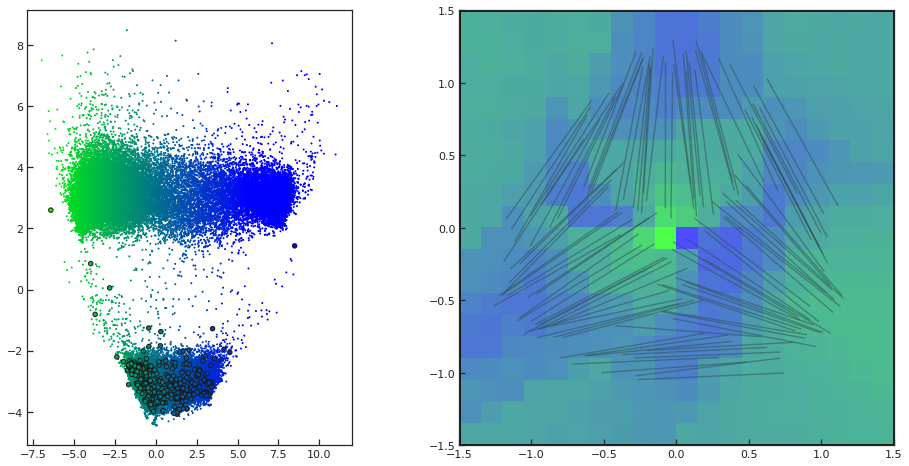

In [132]:
f, ax = plt.subplots(1,2,figsize=(16,8), gridspec_kw={'width_ratios': [1, 1.5]})

_ = ax[0].scatter(Y[:,0],Y[:,1],s=1,c=base_colors)
_ = ax[0].scatter(pca_nbrs[:,0],pca_nbrs[:,1],s=20,c=probecolors,edgecolors='k',linewidths=1)

# Plot rods as background
if not latticemode:
    for i,rod in enumerate(rods):
        plotrods([rod],ax[1],col=probecolors[i],lw=3.0) 
else:
    for i,rod in enumerate(rods):
        plotrods([rod],ax[1],col="darkslategrey",lw=1.4,alpha=0.5)
    # Probe image
    # Your gen_probe function is set that with the transformation below
    # and how imshow plots that things are correct. You can verify
    # with the scatterplot that is commented
    probeimg = probecolors.copy()
    probeimg = probeimg.reshape((nx,nx,3))
    ax[1].imshow(probeimg,alpha=0.7,aspect="auto",extent=(-edge/2,edge/2,-edge/2,edge/2))

radius = 0.5*edge
# ax[1].set_xticks([])
# ax[1].set_yticks([])
boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2,linewidth=3);
ax[1].add_artist(boundary);
# ax[1].axis('off');
ax[1].axis([-radius,radius,-radius,radius])
ax[1].set_aspect("equal")